In [1]:
import numpy as np
import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
import nibabel as nib

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Tensor completion

In this example we will see how can we do tensor completion with t3f, i.e. observe a fraction of values in a tensor and recover the rest by assuming that the original tensor has low TT-rank.
Mathematically it means that we have a binary mask $P$ and a ground truth tensor $A$, but we observe only a noisy and sparsified version of $A$: $P \odot (\hat{A})$, where $\odot$ is the elementwise product (applying the binary mask) and $\hat{A} = A + \text{noise}$. In this case our task reduces to the following optimization problem:
\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \|P \odot (X - \hat{A})\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) \leq r_0
\end{aligned}
\end{equation*}



### Generating problem instance,
Lets generate a random matrix $A$, noise, and mask $P$.

In [2]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)
#x_true_org = image.index_img(x_true_org,1)
x_true_org1 = mt.read_image_abs_path(subject_scan_path)

Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [3]:
x_true_img = np.array(x_true_org.get_data())

In [4]:
#shape = (3, 4, 4, 5, 7, 5)
shape = (53,63,46,144)
# Fix random seed so the results are comparable between runs.
tf.set_random_seed(0)
# Generate ground truth tensor A. To make sure that it has low TT-rank,
# let's generate a random tt-rank 5 tensor and apply t3f.full to it to convert to actual tensor.
#ground_truth = t3f.full(t3f.random_tensor(shape, tt_rank=5))
ground_truth = x_true_img
# Make a (non trainable) variable out of ground truth. Otherwise, it will be randomly regenerated on each sess.run.
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
noise = 1e-2 * tf.get_variable('noise', initializer=tf.random_normal(shape), trainable=False)
noisy_ground_truth = ground_truth
# Observe 25% of the tensor values.
sparsity_mask = tf.cast(tf.random_uniform(shape) <= 0.80, tf.float32)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=sparsity_mask, trainable=False)
sparse_observation = noisy_ground_truth * sparsity_mask

### Initialize the variable and compute the loss

In [5]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [6]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / (frobenius_norm_tf(x_true))
    return percent_error

In [7]:
observed_total = tf.reduce_sum(sparsity_mask)
total = np.prod(shape)
ranks_a = np.array([53,63,46,144,1])
tt_with_ranks = t3f.to_tt_tensor(x_true_img, max_tt_rank=144)
ranks = shapes.tt_ranks(tt_with_ranks)
initialization = t3f.random_tensor(shape, tt_rank=10)
estimated = t3f.get_variable('estimated', initializer=initialization)
# Loss is MSE between the estimated and ground-truth tensor as computed in the observed cells.
loss = tf.reduce_sum((sparsity_mask * t3f.full(estimated) - sparse_observation)**2)/(tf.reduce_sum(sparse_observation)**2)
# Test loss is MSE between the estimated tensor and full (and not noisy) ground-truth tensor A.
test_loss = tf.reduce_sum((t3f.full(estimated) - ground_truth)**2)/(tf.reduce_sum(ground_truth)**2)
rel_error1 = relative_error1(t3f.full(estimated), ground_truth)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 144, 1, 1] 1 (53, 63, 144)
[1, 53, 144, 144, 1] 2 (144, 46, 144)
ranks: [1, 53, 144, 144, 1]


In [8]:
shape

(53, 63, 46, 144)

# SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [9]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01, epsilon=1e-18)
step = optimizer.minimize(loss)

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_loss_hist = []
test_loss_hist = []
for i in range(2):
    _, tr_loss_v, test_loss_v, rel_error1_v, ranks_v = sess.run([step, loss, test_loss,rel_error1, ranks])
    train_loss_hist.append(tr_loss_v)
    test_loss_hist.append(test_loss_v)
    print(i, tr_loss_v, test_loss_v, rel_error1_v, ranks_v)
    #if i % 1000 == 0:
     #   print(i, tr_loss_v, test_loss_v, rel_error1_v)

(0, 9.8959106e-08, 7.915635e-08, 1.0000002, array([  1,  53, 144, 144,   1], dtype=int32))
(1, 9.8959106e-08, 7.915635e-08, 1.0000002, array([  1,  53, 144, 144,   1], dtype=int32))


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


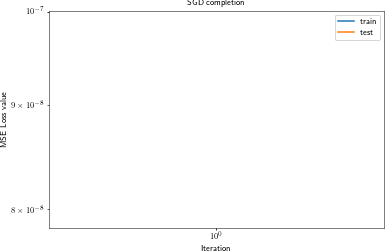

In [11]:
plt.loglog(train_loss_hist, label='train')
plt.loglog(test_loss_hist, label='test')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss value')
plt.title('SGD completion')
plt.legend()


In [12]:
#ground_truth_var = t3f.get_variable('ground_truth', initializer=ground_truth, reuse=True)

In [13]:
#ground_truth.read_value()
ground_truth_val = ground_truth.eval(session=sess)

In [14]:
estimated_val = sess.run(t3f.full(estimated))

In [15]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [16]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [17]:
rel_error

1.0000001

In [18]:
#ten_ones = np.ones_like(mask)
#x_reconstr = mt.reconstruct(x_hat,x_true, ten_ones, mask)

In [19]:
estimated_val.shape

(53, 63, 46, 144)

In [20]:
from nilearn import image

In [21]:
shape = (53,63,46,144)

In [22]:
sparse_observation_val=sparse_observation.eval(session=sess)

In [23]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, sparse_observation_val)

In [24]:
#x_miss = x_miss_img
x_miss = image.index_img(x_miss_img,1)

In [25]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, estimated_val)


In [26]:
#x_hat = x_hat_img
x_hat = image.index_img(x_hat_img,1)

In [27]:
from nilearn import plotting

In [28]:
x_true_org = image.index_img(x_true_org,1)

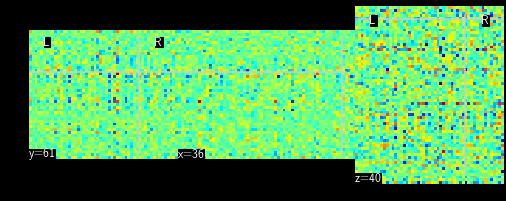

In [29]:
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

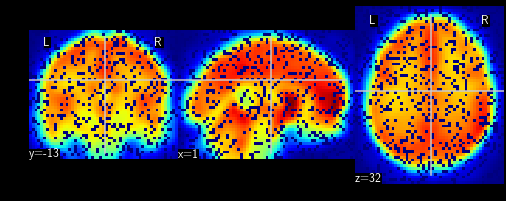

In [30]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [31]:
import ellipsoid_masker as elpm
import ellipsoid_mask as em

In [32]:
def create_corrupted_image(x0,y0,z0, x_r, y_r):
    pass

In [33]:
def generate_structural_missing_pattern(x0,y0,z0, x_r, y_r, frames_count, path_folder):
    subject_scan_path = du.get_full_path_subject1()
        
    print ("3D Random Missing Value Pattern Simulations has started...")
    print "Subject Path: " + str(subject_scan_path)
    
    n = 0
    # type 1 (center is the center of the image), corrupt first 10 frames
    #x0, y0, z0 = (0 ,-18 , 17)
    #x_r, y_r, z_r = (20, 17, 15)
    
    print "===Type 1 Experiments===="
    
    target_img = image.index_img(subject_scan_path,n)
    
    type_1_folder_path = path_folder
    masked_img_file_path  = type_1_folder_path + "/" + "size_" + str(x_r) + "_" + str(y_r) + "_" + str(z_r) + "_scan_" + str(n)
    
    corrupted_volumes_list = []
    corrupted_volumes_list_scan_numbers = []
    
    for i in xrange(frames_count):
        masked_img_file_path  = type_1_folder_path + "/" + "size_" + str(x_r) + "_" + str(y_r) + "_" + str(z_r) + "_scan_" + str(i)
        target_img = image.index_img(subject_scan_path,i)
        image_masked_by_ellipsoid = elpm.create_ellipsoid_mask(x0, y0, z0, x_r, y_r, z_r, target_img, masked_img_file_path)
        
        masked_img_file_path = masked_img_file_path + ".nii"
        ellipsoid = em.EllipsoidMask(x0, y0, z0, x_r, y_r, z_r, masked_img_file_path)
        ellipsoid_volume = ellipsoid.volume()
        observed_ratio = mt.compute_observed_ratio(image_masked_by_ellipsoid)
        
        corrupted_volumes_list.append(image_masked_by_ellipsoid)
        corrupted_volumes_list_scan_numbers.append(i)
        print ("Ellipsoid Volume: " + str(ellipsoid_volume) + "; Missing Ratio: " + str(observed_ratio))
    
    # now create corrupted 4d where fist 10 frames has ellipsoid missing across 10 frames
    counter = 0
    
    volumes_list = []
    for img in image.iter_img(subject_scan_path):
        print "Volume Index: " + str(counter)
        if counter in corrupted_volumes_list_scan_numbers:
            print "Adding corrupted volume to the list " + str(counter)
            volumes_list.append(corrupted_volumes_list[counter])
        else:
            print "Adding normal volume to the list " + str(counter)
            volumes_list.append(img)
        counter = counter + 1
        
    # now generate corrupted 4D from the list
    corrupted4d_10 = image.concat_imgs(volumes_list)
    print "Corrupted 4D - 10 frames: " + str(corrupted4d_10)
    observed_ratio4D_10 = mt.compute_observed_ratio(corrupted4d_10)
    print ("Corrupted 4D - 10 Volume: " + "; Missing Ratio: " + str(observed_ratio4D_10))
    corr_file_path4D = du.corrupted4D_10_frames_path()
    nib.save(corrupted4d_10, corr_file_path4D)
    return corrupted4d_10

In [34]:
def get_xyz(i, j, k, epi_img):
    M = epi_img.affine[:3, :3]
    abc = epi_img.affine[:3, 3]
    return M.dot([i, j, k]) + abc

In [35]:
coord = [26,31,23]
path_folder3D = "/work/el/3D"

In [36]:
x_true_org3D = image.index_img(subject_scan_path,0)
nib.save(x_true_org3D,path_folder3D)

In [37]:
x_coord  = get_xyz(10,7,4, x_true_org3D)

In [38]:
x_coord

array([ 48., -90., -39.])

In [39]:
path_folder3D = "/work/el/3D"

In [40]:
path_folder = "/work/el/75"

In [41]:
#x0, y0, z0 = (-10, -20,17)
#x0, y0, z0 = (-5, -20,17)
#x0, y0, z0 = (2, 32,22)
#x_r, y_r, z_r = (20,17,15)
x0, y0, z0 = (2, 32,22)
# size 1
#x_r, y_r, z_r = (7,10,8)
# size 2
#x_r, y_r, z_r = (9,10,8)
#size 3
x_r, y_r, z_r = (12,10,8)

In [42]:
#x_miss_img = generate_structural_missing_pattern(x0,y0,z0, x_r, y_r, 1, path_folder)

In [43]:
x_miss_img

In [44]:
x_miss_img_data = np.array(x_miss_img.get_data())

In [45]:
import copy

In [46]:
x_miss_mask = copy.deepcopy(x_miss_img_data)

In [47]:
x_miss_mask = (x_miss_img_data==0).astype('int') 

In [48]:
x_miss_mask.shape

(53, 63, 46, 144)

In [49]:
x_miss_img_data.shape

(53, 63, 46, 144)

In [50]:
print x_true_org

<class 'nibabel.nifti1.Nifti1Image'>
data shape (53, 63, 46)
affine: 
[[  -3.    0.    0.   78.]
 [   0.    3.    0. -111.]
 [   0.    0.    3.  -51.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : r
dim_info        : 0
dim             : [ 3 53 63 46  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 33505.785
cal_min         : 101.88748
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : spm - 3D normalized
aux_file        : 
qform_code      : aligned
sform_

In [51]:
target_img = image.index_img(x_true_org1,0)

In [52]:
masked_img_file_path  = "/work/el" + "/" + "size_" + str(x_r) + "_" + str(y_r) + "_" + str(z_r) + "_scan_" + str(i)

In [53]:
masked_img_file_path

'/work/el/size_12_10_8_scan_1'

In [54]:
#image_masked_by_ellipsoid = elpm.create_ellipsoid_mask(x0, y0, z0, x_r, y_r, z_r, target_img, masked_img_file_path)

In [55]:
target_img